In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc

In [2]:
def XGB(X,y):
    #Train and valid split
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # XGB Classifier
    clf = xgb.XGBClassifier()
    #y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = clf.predict(X_val)
    
    #Probability estimates
    pred_probs = clf.predict_proba(X_val)
    
    
    #Model Evaultion Metrics
    accuracy = metrics.accuracy_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    cf_matrix = metrics.confusion_matrix(y_val,y_pred)
    
    probs_isgoal = pred_probs[:,1]
    roc_auc = metrics.roc_auc_score(y_val,probs_isgoal)
    
        
    return pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix

In [3]:
# Read in data and assign X and y
data = pd.read_csv('../../data/train.csv', index_col=0)
X = data[data.columns.tolist()[:-1]]
#y = data[['isGoal']]
y = data[['isGoal']].values.ravel()
X

,time,period,coordinateX,coordinateY,shotDistance,shotAngle,shotType,emptyNet,lastEventType,lastCoordinateX,lastCoordinateY,lastTime,lastShotDistance,rebound,changeShotAngle,speed,friendlyPlayersOnIce,opposingPlayersOnIce,timeSincePP
gameId,,,,,,,,,,,,,,,,,,,
2015020001,51,1,-55.0,6.0,34.5254,10.0080,6,0,5,94.0,-34.0,11,154.2757,0,0.0000,14.0251,5,5,0
2015020001,65,1,-79.0,0.0,10.0000,0.0000,3,0,3,-37.0,-28.0,7,50.4777,0,0.0000,7.2111,5,5,0
2015020001,66,1,-75.0,-1.0,14.0357,-4.0856,3,0,14,-79.0,0.0,1,4.1231,1,-4.0856,4.1231,5,5,0
2015020001,113,1,-55.0,-36.0,49.5177,-46.6366,6,0,5,-91.0,35.0,18,79.6053,0,0.0000,4.4225,5,5,0
2015020001,157,1,-61.0,-1.0,28.0179,-2.0454,4,0,1,-69.0,-22.0,5,22.4722,0,0.0000,4.4944,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018021271,3337,3,67.0,-19.0,29.0689,-40.8151,2,0,3,29.0,35.0,33,66.0303,0,0.0000,2.0009,5,5,0
2018021271,3393,3,-78.0,1.0,11.0454,5.1944,6,0,1,-69.0,-22.0,29,24.6982,0,0.0000,0.8517,5,5,0
2018021271,3519,3,-82.0,10.0,12.2066,55.0080,6,0,6,-71.0,4.0,19,12.5300,0,0.0000,0.6595,5,5,0


In [4]:
col_list = X.columns.to_list()
feature_names = np.array(X.columns.to_list())
print(feature_names)

['time' 'period' 'coordinateX' 'coordinateY' 'shotDistance' 'shotAngle'
 'shotType' 'emptyNet' 'lastEventType' 'lastCoordinateX' 'lastCoordinateY'
 'lastTime' 'lastShotDistance' 'rebound' 'changeShotAngle' 'speed'
 'friendlyPlayersOnIce' 'opposingPlayersOnIce' 'timeSincePP']


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

X = X.copy()
tot_col = len(X.columns)

min_max_scaler = MinMaxScaler()
X[col_list] = min_max_scaler.fit_transform(X[col_list])

#y = y.values.ravel()

# Lasso SVC
C_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 50, 100, 1000]
for c in C_list:
    lsvc = LinearSVC(C=c, penalty="l1", max_iter = 10000, dual=False).fit(X, y)

    # Select features based on Lasso
    selector = SelectFromModel(lsvc)

    selector.fit(X,y)

    #print('Selected Support : ', selector.get_support())

    #print('Selected Features: ', feature_names[selector.get_support()])


    features = selector.transform(X)
    print('Selected Features shape: ', features.shape)
    
    pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = XGB(features, y)
    print(f' C: {c} accuracy: {accuracy: 6.4}, f1_score: {f1_score: 6.4}, precision: {precision :6.4},\
    recall: {recall: 6.4}, roc_auc: {roc_auc: 6.4}')

Selected Features shape:  (315532, 11)
 C: 0.001 accuracy:  0.9065, f1_score:  0.1678, precision: 0.7788,    recall:  0.09404, roc_auc:  0.799
Selected Features shape:  (315532, 17)
 C: 0.005 accuracy:  0.9073, f1_score:  0.1823, precision: 0.7874,    recall:  0.1031, roc_auc:  0.8016
Selected Features shape:  (315532, 16)
 C: 0.01 accuracy:  0.907, f1_score:  0.1799, precision: 0.7731,    recall:  0.1018, roc_auc:  0.8007
Selected Features shape:  (315532, 16)
 C: 0.05 accuracy:  0.9069, f1_score:  0.1793, precision: 0.7698,    recall:  0.1015, roc_auc:  0.8022
Selected Features shape:  (315532, 16)
 C: 0.1 accuracy:  0.9069, f1_score:  0.1793, precision: 0.7698,    recall:  0.1015, roc_auc:  0.8022
Selected Features shape:  (315532, 19)
 C: 0.5 accuracy:  0.9072, f1_score:  0.1891, precision: 0.7623,    recall:  0.108, roc_auc:  0.8042
Selected Features shape:  (315532, 19)
 C: 1.0 accuracy:  0.9072, f1_score:  0.1891, precision: 0.7623,    recall:  0.108, roc_auc:  0.8042
Selected F

In [6]:
#Selected C =  0.1 based on above hyperparameter search

lsvc = LinearSVC(C=0.1, penalty="l1", max_iter = 10000, dual=False).fit(X, y)

# Select features based on Lasso
selector = SelectFromModel(lsvc)
selector.fit(X,y)
selected_features =    feature_names[selector.get_support()]
print('Selected Features: ', feature_names[selector.get_support()])

Selected Features:  ['period' 'coordinateX' 'shotDistance' 'shotAngle' 'shotType' 'emptyNet'
 'lastEventType' 'lastCoordinateX' 'lastCoordinateY' 'lastTime'
 'lastShotDistance' 'rebound' 'speed' 'friendlyPlayersOnIce'
 'opposingPlayersOnIce' 'timeSincePP']


In [7]:
#

In [8]:
X_new = X[selected_features]
pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = XGB(X_new, y)
print(f' accuracy: {accuracy}')
print(f' f1_score: {f1_score}')
print(f' precision: {precision}')
print(f' recall: {recall}')
print(f' roc_auc: {roc_auc}')
print(cf_matrix)

 accuracy: 0.9068724547197616
 f1_score: 0.1793045664013406
 precision: 0.7697841726618705
 recall: 0.10146989094357516
 roc_auc: 0.8022462257589527
[[56588   192]
 [ 5685   642]]


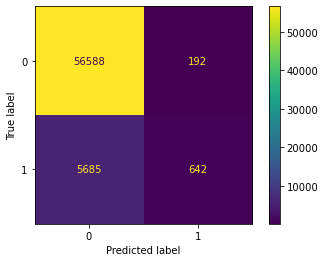

In [9]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()